**imports**

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 40000)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', 3000)

import  matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import regexp_tokenize 
from string import punctuation
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import re

import string
from string import punctuation

stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**create dataframe for bernie's tweets**

In [0]:
path = '/content/drive/My Drive/datasets/bernie.csv'
df_bernie = pd.read_csv(path)
#drop duplicate articles on original df_bernieset
df_bernie.drop_duplicates(subset="text",keep = "first", inplace = True)
print("Total retrieved articles: ",df_bernie.shape[0])
print(df_bernie.shape)
df_bernie.head()

Total retrieved articles:  9800
(9800, 3)


,username,text,date
0,BernieSanders,It's outrageous that during this time essentia...,2020-04-04
1,BernieSanders,The coronavirus does not differentiate based o...,2020-04-04
2,BernieSanders,Hotspots like NYC are in dire need of supplies...,2020-04-04
3,BernieSanders,Your health care cannot be tied to your employ...,2020-04-04
4,BernieSanders,We have a responsibility to ensure no person g...,2020-04-03


**text preproccess**

In [0]:
#make all text lowercase
df_bernie['clean_text'] = df_bernie['text'].str.lower()


In [0]:
#remove words < 2 chars
df_bernie['clean_text'] = df_bernie['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

#remove links with regex
p=re.compile('(www|http)\S+')
df_bernie['clean_text'] = df_bernie['clean_text'].apply(lambda x: re.sub(p,' ',x))
#remove @
df_bernie['clean_text'] = df_bernie['clean_text'].apply(lambda x: re.sub('@','',x))

#remove punctuation

In [0]:
#remove stopwords function
stops =  list(stopwords) + list(punctuation)

def remove_stops(text):
    text_no_stops = []
    for i in text:
        if i not in stops:
            if len(i) == 1:
                pass
            else:
                text_no_stops.append(i)
        else:
            pass
    return text_no_stops




In [0]:
#tokenize
df_bernie['text_tokenized'] = df_bernie['clean_text'].apply(lambda x: regexp_tokenize(x,"[\w']+"))


In [0]:
#actually remove stopwords
df_bernie['text_tokenized'] = df_bernie['text_tokenized'].apply(lambda x: remove_stops(x))

In [0]:
#lematization function
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

In [0]:
#lemmatize

df_bernie['text_lemma'] = df_bernie['text_tokenized'].apply(lemmatize_text)

In [0]:
#create a string from lemmatized words

df_bernie['lemmatized_string'] = df_bernie['text_lemma'].apply(lambda x: ' '.join(x))

In [0]:
#check the dataframe
df_bernie.head()

,username,text,date,clean_text,text_tokenized,text_lemma,lemmatized_string
0,BernieSanders,It's outrageous that during this time essentia...,2020-04-04,it's outrageous that during this time essentia...,"[outrageous, time, essential, workers, forced,...","[outrageous, time, essential, worker, forced, ...",outrageous time essential worker forced work w...
1,BernieSanders,The coronavirus does not differentiate based o...,2020-04-04,the coronavirus does not differentiate based i...,"[coronavirus, differentiate, based, immigratio...","[coronavirus, differentiate, based, immigratio...",coronavirus differentiate based immigration st...
2,BernieSanders,Hotspots like NYC are in dire need of supplies...,2020-04-04,hotspots like nyc are dire need supplies prote...,"[hotspots, like, nyc, dire, need, supplies, pr...","[hotspot, like, nyc, dire, need, supply, prote...",hotspot like nyc dire need supply protect heal...
3,BernieSanders,Your health care cannot be tied to your employ...,2020-04-04,your health care cannot tied your employment. ...,"[health, care, cannot, tied, employment, seen,...","[health, care, cannot, tied, employment, seen,...",health care cannot tied employment seen human ...
4,BernieSanders,We have a responsibility to ensure no person g...,2020-04-03,have responsibility ensure person goes hungry ...,"[responsibility, ensure, person, goes, hungry,...","[responsibility, ensure, person, go, hungry, c...",responsibility ensure person go hungry crisis ...


In [0]:
# tfidf vectorizer of scikit learn

vectorizer = TfidfVectorizer(stop_words=stopwords,use_idf = True, ngram_range=(1,2))
#vectorize lemmatized tweets
X = vectorizer.fit_transform(df_bernie['lemmatized_string'])
terms = vectorizer.get_feature_names()


In [0]:
df_bernie.head()

,username,text,date,clean_text,text_tokenized,text_lemma,lemmatized_string
0,BernieSanders,It's outrageous that during this time essentia...,2020-04-04,it's outrageous that during this time essentia...,"[outrageous, time, essential, workers, forced,...","[outrageous, time, essential, worker, forced, ...",outrageous time essential worker forced work w...
1,BernieSanders,The coronavirus does not differentiate based o...,2020-04-04,the coronavirus does not differentiate based i...,"[coronavirus, differentiate, based, immigratio...","[coronavirus, differentiate, based, immigratio...",coronavirus differentiate based immigration st...
2,BernieSanders,Hotspots like NYC are in dire need of supplies...,2020-04-04,hotspots like nyc are dire need supplies prote...,"[hotspots, like, nyc, dire, need, supplies, pr...","[hotspot, like, nyc, dire, need, supply, prote...",hotspot like nyc dire need supply protect heal...
3,BernieSanders,Your health care cannot be tied to your employ...,2020-04-04,your health care cannot tied your employment. ...,"[health, care, cannot, tied, employment, seen,...","[health, care, cannot, tied, employment, seen,...",health care cannot tied employment seen human ...
4,BernieSanders,We have a responsibility to ensure no person g...,2020-04-03,have responsibility ensure person goes hungry ...,"[responsibility, ensure, person, goes, hungry,...","[responsibility, ensure, person, go, hungry, c...",responsibility ensure person go hungry crisis ...


**K-MEANS clustering**

**find best K by using elbow rule**

In [0]:
'''distortions = []
    K = range(150,160)
    for k in K:
        km = KMeans(n_clusters=k)
        km.fit(X)
        distortions.append(km.inertia_)'''

'distortions = []\n    K = range(150,160)\n    for k in K:\n        km = KMeans(n_clusters=k)\n        km.fit(X)\n        distortions.append(km.inertia_)'

In [0]:
   ''' plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()'''

" plt.figure(figsize=(16,8))\n plt.plot(K, distortions, 'bx-')\n plt.xlabel('k')\n plt.ylabel('Distortion')\n plt.title('The Elbow Method showing the optimal k')\n plt.show()"

In [0]:
df_bernie.head()

,username,text,date,clean_text,text_tokenized,text_lemma,lemmatized_string
0,BernieSanders,It's outrageous that during this time essentia...,2020-04-04,it's outrageous that during this time essentia...,"[outrageous, time, essential, workers, forced,...","[outrageous, time, essential, worker, forced, ...",outrageous time essential worker forced work w...
1,BernieSanders,The coronavirus does not differentiate based o...,2020-04-04,the coronavirus does not differentiate based i...,"[coronavirus, differentiate, based, immigratio...","[coronavirus, differentiate, based, immigratio...",coronavirus differentiate based immigration st...
2,BernieSanders,Hotspots like NYC are in dire need of supplies...,2020-04-04,hotspots like nyc are dire need supplies prote...,"[hotspots, like, nyc, dire, need, supplies, pr...","[hotspot, like, nyc, dire, need, supply, prote...",hotspot like nyc dire need supply protect heal...
3,BernieSanders,Your health care cannot be tied to your employ...,2020-04-04,your health care cannot tied your employment. ...,"[health, care, cannot, tied, employment, seen,...","[health, care, cannot, tied, employment, seen,...",health care cannot tied employment seen human ...
4,BernieSanders,We have a responsibility to ensure no person g...,2020-04-03,have responsibility ensure person goes hungry ...,"[responsibility, ensure, person, goes, hungry,...","[responsibility, ensure, person, go, hungry, c...",responsibility ensure person go hungry crisis ...


In [0]:
#K-means clustering
num_clusters = 40
km = KMeans(n_clusters=num_clusters,init='k-means++')
labels = km.fit_predict(X)


In [0]:
print("K-means clustering: \n")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print('\n')


K-means clustering: 

Cluster 0:
 energy
 energy system
 system
 change
 away fossil
 climate change
 fossil fuel
 fossil
 fuel
 climate


Cluster 1:
 wall street
 wall
 street
 big
 greed
 bank
 billionaire
 economy
 breakemup
 illegal behavior


Cluster 2:
 insurance
 health insurance
 medicare
 gun
 health
 american
 million
 insurance company
 company
 deductible


Cluster 3:
 college
 tuition
 free
 tuition free
 public college
 public
 university
 college university
 make public
 university tuition


Cluster 4:
 economy
 economy work
 work
 create economy
 create
 government
 government economy
 billionaire
 going create
 top


Cluster 5:
 party
 democratic
 process
 democratic party
 political process
 political
 people
 involved
 people political
 million people


Cluster 6:
 drug
 price
 prescription
 prescription drug
 company
 drug company
 drug price
 american
 industry
 pharmaceutical


Cluster 7:
 young
 young people
 people
 country
 transform
 future
 generation
 transf

In [0]:
#add cluster label to dataframe
df_bernie['cluster'] = labels


In [0]:
df_bernie.head()

,username,text,date,clean_text,text_tokenized,text_lemma,lemmatized_string,cluster
0,BernieSanders,It's outrageous that during this time essentia...,2020-04-04,it's outrageous that during this time essentia...,"[outrageous, time, essential, workers, forced,...","[outrageous, time, essential, worker, forced, ...",outrageous time essential worker forced work w...,11
1,BernieSanders,The coronavirus does not differentiate based o...,2020-04-04,the coronavirus does not differentiate based i...,"[coronavirus, differentiate, based, immigratio...","[coronavirus, differentiate, based, immigratio...",coronavirus differentiate based immigration st...,25
2,BernieSanders,Hotspots like NYC are in dire need of supplies...,2020-04-04,hotspots like nyc are dire need supplies prote...,"[hotspots, like, nyc, dire, need, supplies, pr...","[hotspot, like, nyc, dire, need, supply, prote...",hotspot like nyc dire need supply protect heal...,16
3,BernieSanders,Your health care cannot be tied to your employ...,2020-04-04,your health care cannot tied your employment. ...,"[health, care, cannot, tied, employment, seen,...","[health, care, cannot, tied, employment, seen,...",health care cannot tied employment seen human ...,16
4,BernieSanders,We have a responsibility to ensure no person g...,2020-04-03,have responsibility ensure person goes hungry ...,"[responsibility, ensure, person, goes, hungry,...","[responsibility, ensure, person, go, hungry, c...",responsibility ensure person go hungry crisis ...,8


**plot cluster size**

In [0]:
import seaborn as sns
sns.set(rc={'figure.figsize':(13,9)})
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


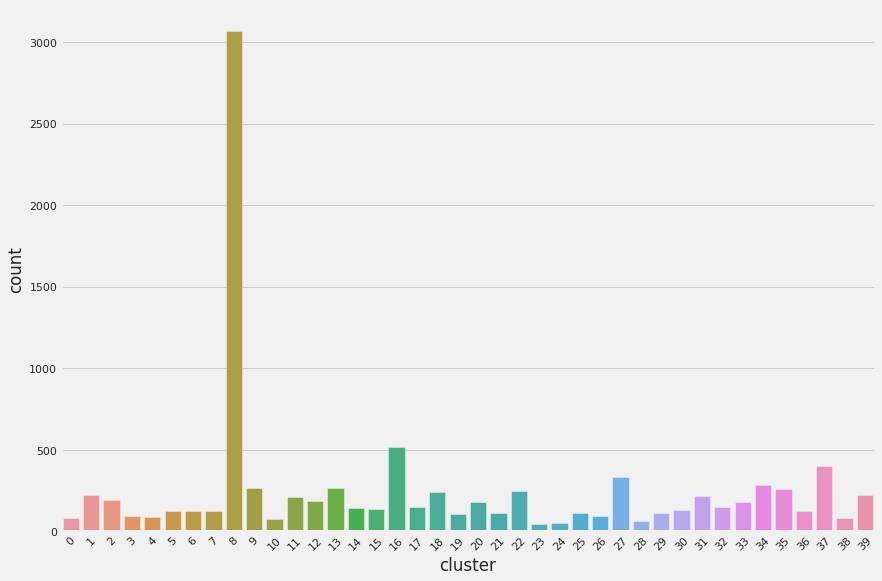

In [0]:
ax = sns.countplot(x= 'cluster', data=df_bernie)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

**plot the clusters**

**sentiment analysis**

In [0]:
from textblob import TextBlob

In [0]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    #return  analysis.sentiment.polarity
    
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity == 0:
        return "neutral"
    else:
        return "negative"

In [0]:
df_bernie['sentiment'] = np.array([ analyze_sentiment(tweet) for tweet in df_bernie['lemmatized_string'] ])

In [0]:
df_bernie.head()

,username,text,date,clean_text,text_tokenized,text_lemma,lemmatized_string,cluster,sentiment
0,BernieSanders,It's outrageous that during this time essentia...,2020-04-04,it's outrageous that during this time essentia...,"[outrageous, time, essential, workers, forced,...","[outrageous, time, essential, worker, forced, ...",outrageous time essential worker forced work w...,11,negative
1,BernieSanders,The coronavirus does not differentiate based o...,2020-04-04,the coronavirus does not differentiate based i...,"[coronavirus, differentiate, based, immigratio...","[coronavirus, differentiate, based, immigratio...",coronavirus differentiate based immigration st...,25,positive
2,BernieSanders,Hotspots like NYC are in dire need of supplies...,2020-04-04,hotspots like nyc are dire need supplies prote...,"[hotspots, like, nyc, dire, need, supplies, pr...","[hotspot, like, nyc, dire, need, supply, prote...",hotspot like nyc dire need supply protect heal...,16,negative
3,BernieSanders,Your health care cannot be tied to your employ...,2020-04-04,your health care cannot tied your employment. ...,"[health, care, cannot, tied, employment, seen,...","[health, care, cannot, tied, employment, seen,...",health care cannot tied employment seen human ...,16,positive
4,BernieSanders,We have a responsibility to ensure no person g...,2020-04-03,have responsibility ensure person goes hungry ...,"[responsibility, ensure, person, goes, hungry,...","[responsibility, ensure, person, go, hungry, c...",responsibility ensure person go hungry crisis ...,8,neutral


**persentage of positive/negative/neutral tweets**

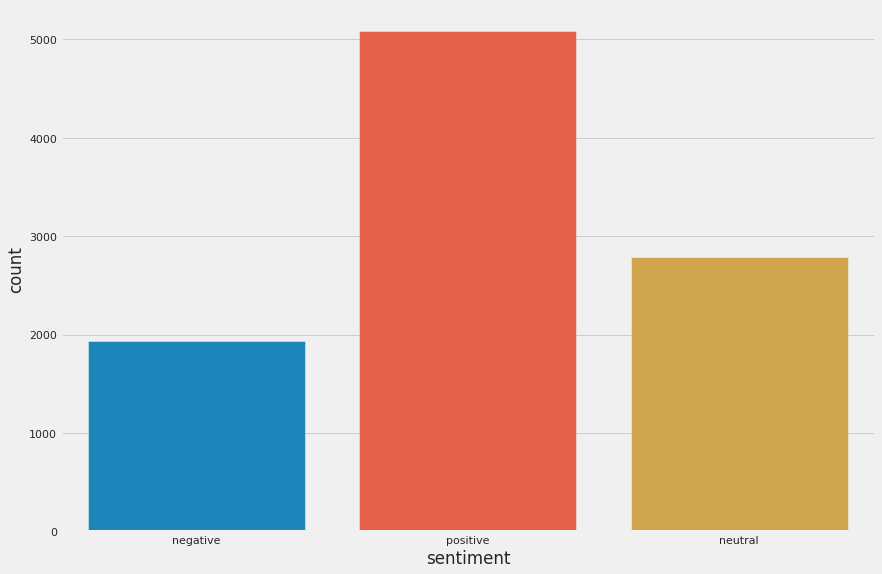

In [0]:
ax = sns.countplot(x= 'sentiment', data=df_bernie)
plt.show()

**find popular hashtags**

In [0]:
#create new df hashtags
hashtags = df_bernie["text"].str.extractall(r'(\#\w+)')[0].value_counts().reset_index()

In [0]:
hashtags.columns=['tag','count']

Text(0.5, 1.0, '25 more popular hashtags used by Bernie Sanders')

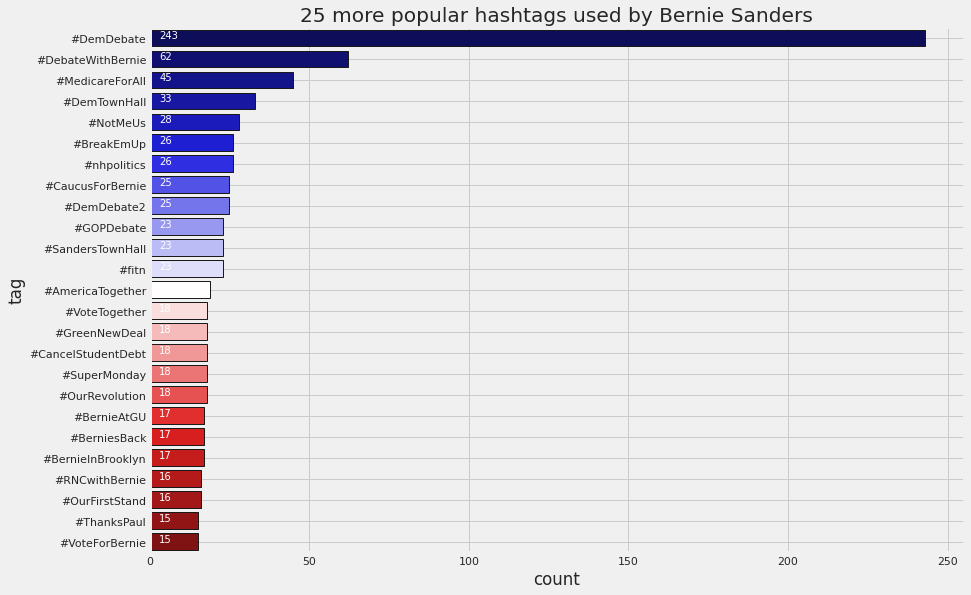

In [0]:
ax = sns.barplot(x = "count" , y = "tag" ,
                 data = hashtags[:25] , palette = "seismic",
                 linewidth = 1 , edgecolor = "k")
plt.grid(True)
for i,j in enumerate(hashtags["count"][:25].values) :
    ax.text(3,i,j,fontsize = 10,color = "white")
plt.title("25 more popular hashtags used by Bernie Sanders")

**popular account handlers used**

In [0]:
#create new df accounts
accounts = df_bernie["text"].str.extractall(r'(\@\w+)')[0].value_counts().reset_index()

In [0]:
accounts.columns=['username','count']

Text(0.5, 1.0, '25 more popular usernames mentioned by Bernie Sanders')

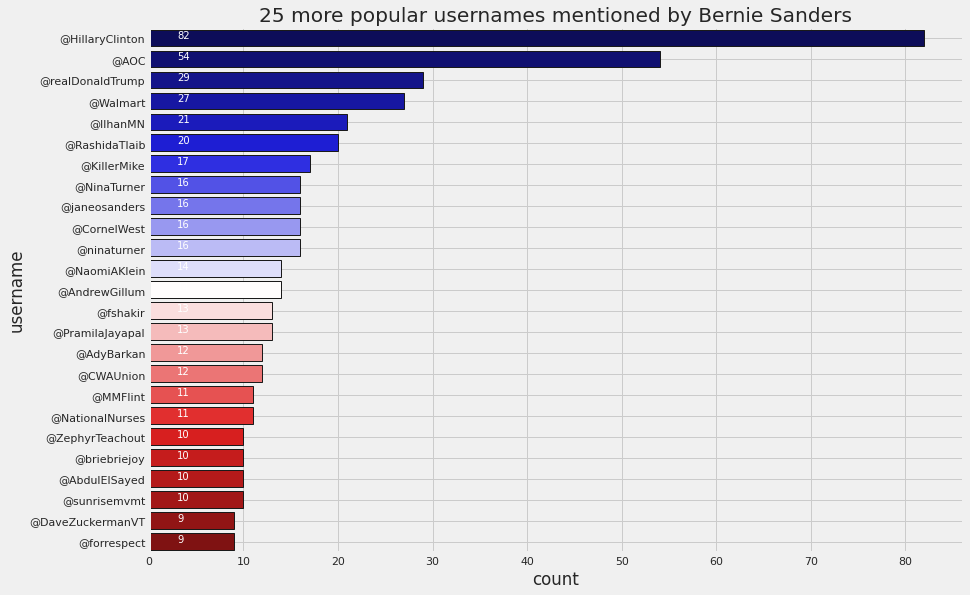

In [0]:
ax = sns.barplot(x = "count" , y = "username" ,
                 data = accounts[:25] , palette = "seismic",
                 linewidth = 1 , edgecolor = "k")
plt.grid(True)
for i,j in enumerate(accounts["count"][:25].values) :
    ax.text(3,i,j,fontsize = 10,color = "white")
plt.title("25 more popular usernames mentioned by Bernie Sanders")

**network analysis**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx

In [0]:
def network_tweets(df,frequency,color,title) :
    #documents
    documents  = df["lemmatized_string"].tolist()
    vectorizer = CountVectorizer()
    vec        = vectorizer.fit_transform(documents)
    vec_t      = vectorizer.fit_transform(documents).transpose()
    
    #adjecency matrix for words
    adj_mat    = pd.DataFrame((vec_t * vec).toarray(),
                              columns = vectorizer.get_feature_names(),
                              index    = vectorizer.get_feature_names()
                             )
    # #stacking combinations
    adj_mat_stack   = adj_mat.stack().reset_index()
    adj_mat_stack.columns = ["link_1","link_2","count"]
    
    #drop same word combinations
    adj_mat_stack   = adj_mat_stack[adj_mat_stack["link_1"] !=
                                    adj_mat_stack["link_2"]] 
    
    #subset dataframe with combination count greater than x times
    network_sub = adj_mat_stack[adj_mat_stack["count"] > frequency]
    
    #plot network
    H = nx.from_pandas_edgelist(network_sub,"link_1","link_2",["count"],
                                create_using = nx.DiGraph())

    ax = plt.figure(figsize = (18,18))
    nx.draw(H,with_labels = True,alpha = .7,node_shape = "H",
            width = 1,node_color = color,
            font_weight = "bold",style = "solid", arrowsize = 15 ,
            font_color = "white",linewidths = 10,edge_color = "grey",
            node_size = 1300,pos = nx.kamada_kawai_layout(H))
    plt.title(title,color = "white")
    ax.set_facecolor("k")

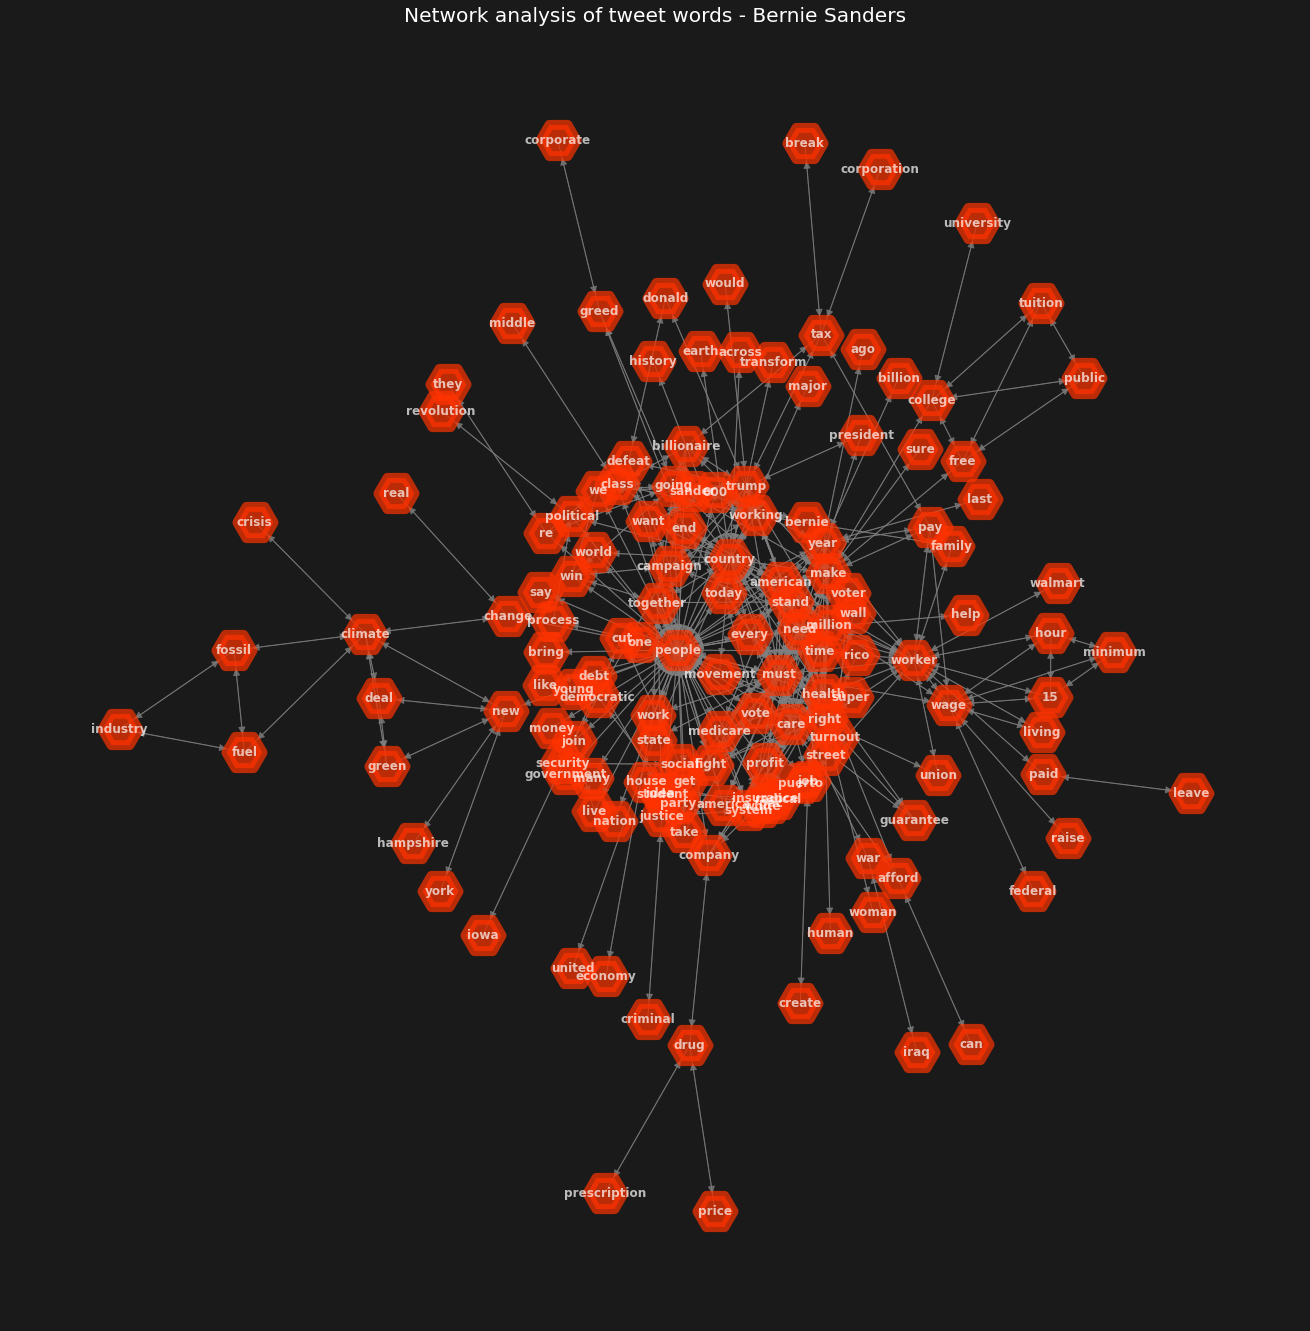

In [0]:
network_tweets(df_bernie,80,"#FF3300","Network analysis of tweet words - Bernie Sanders")

**tweets per year plot**

In [0]:
#create column year
df_bernie['year'] = df_bernie['date'].apply(lambda buf: int(buf[:4]))

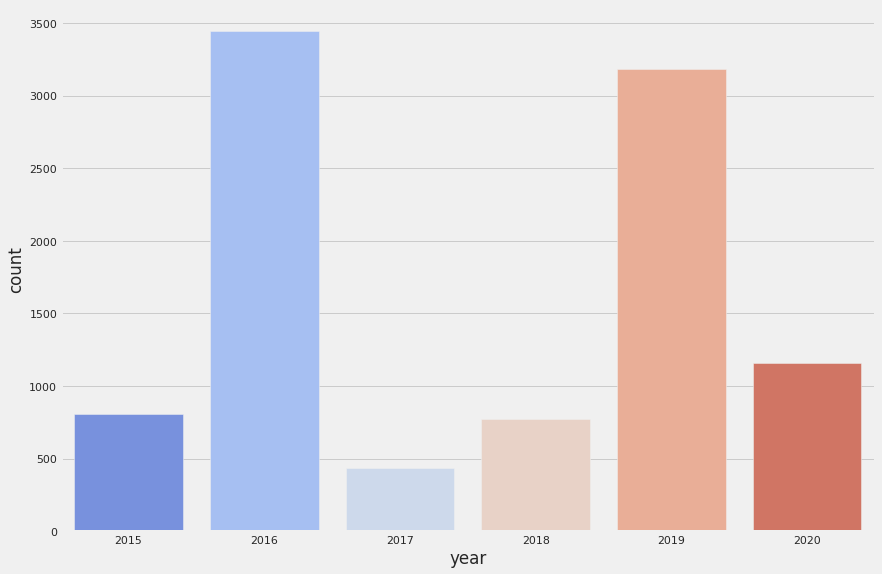

In [0]:
sns.countplot(x='year',data=df_bernie, palette = 'coolwarm')

**Tweet numbers incrases dramatically at 2016,2019 -> Democratic Party elections**

**WordCloud Generation**

In [0]:
dummy = df_bernie[df_bernie['cluster']==15]

In [0]:
text = df_bernie.lemmatized_string

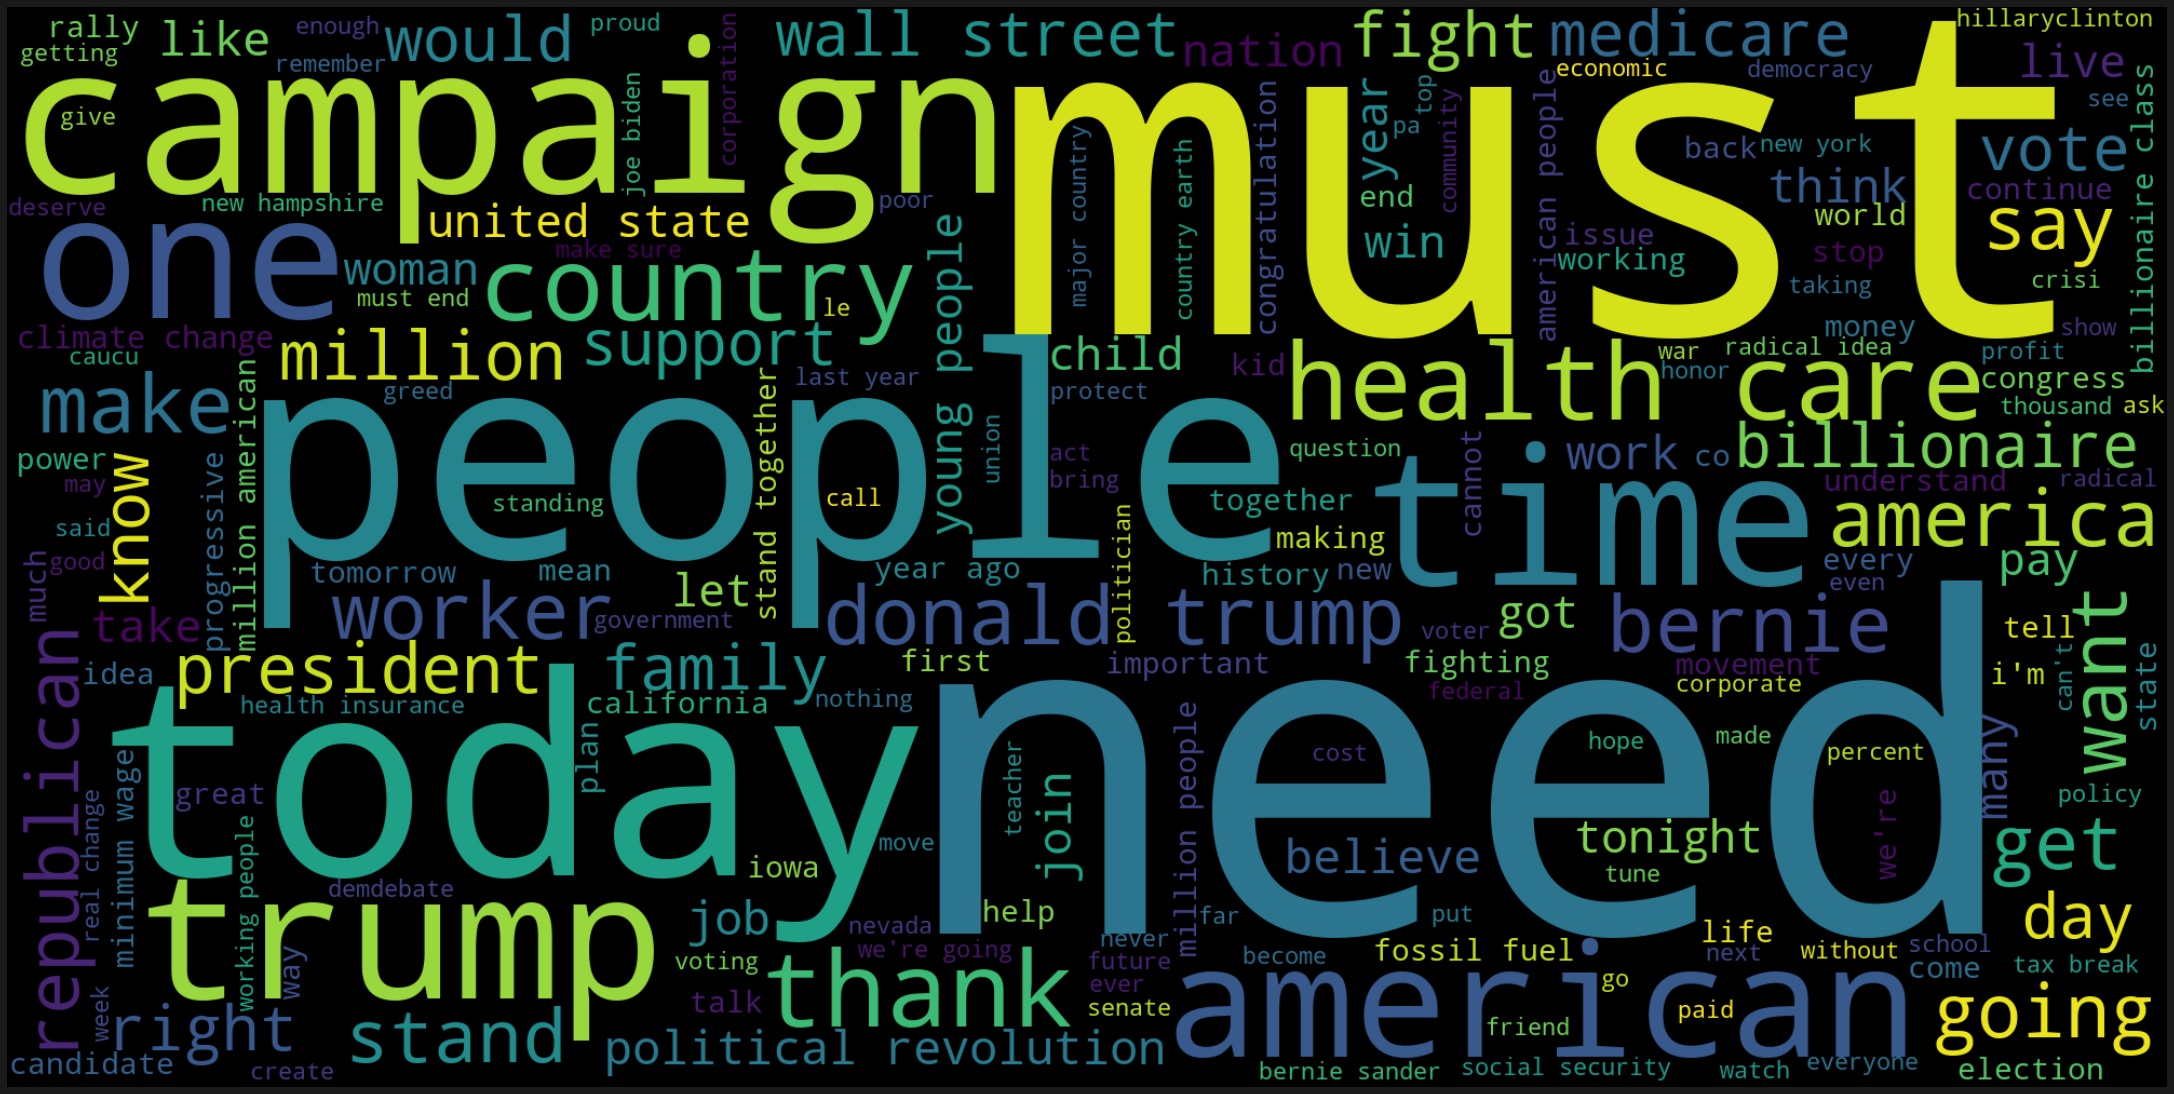

In [0]:
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = stopwords).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**create new df for tweets refering to trump**

In [0]:
keywords = ['trump']
trump = pd.DataFrame()

In [0]:
for k in keywords :
  tmp = df_bernie[df_bernie['text'].str.lower().str.contains(k)]
  trump = trump.append(tmp)

trump = trump.reset_index(drop=True)

In [0]:
trump.drop("cluster", axis=1, inplace=True)

**sentiment of tweets regarding trump**

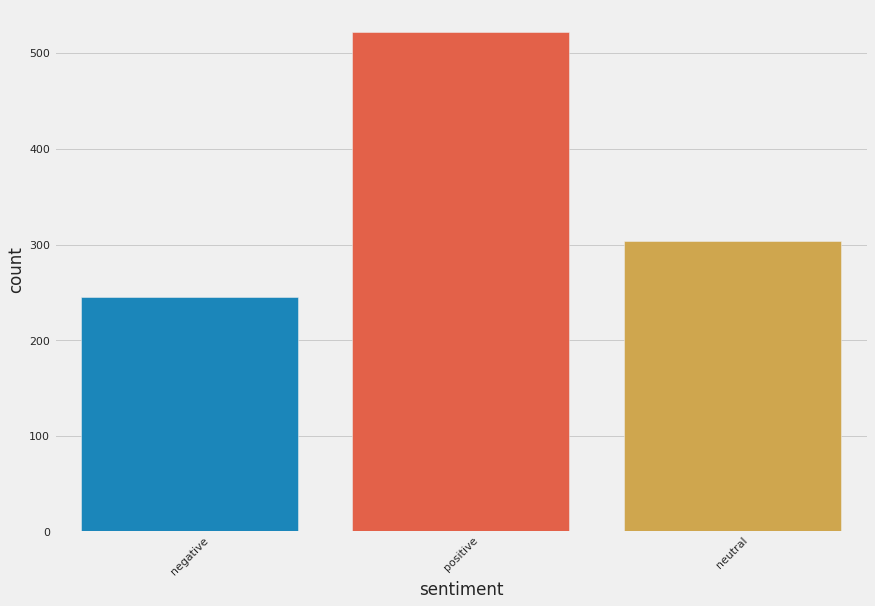

In [0]:
ax = sns.countplot(x= 'sentiment', data=trump)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

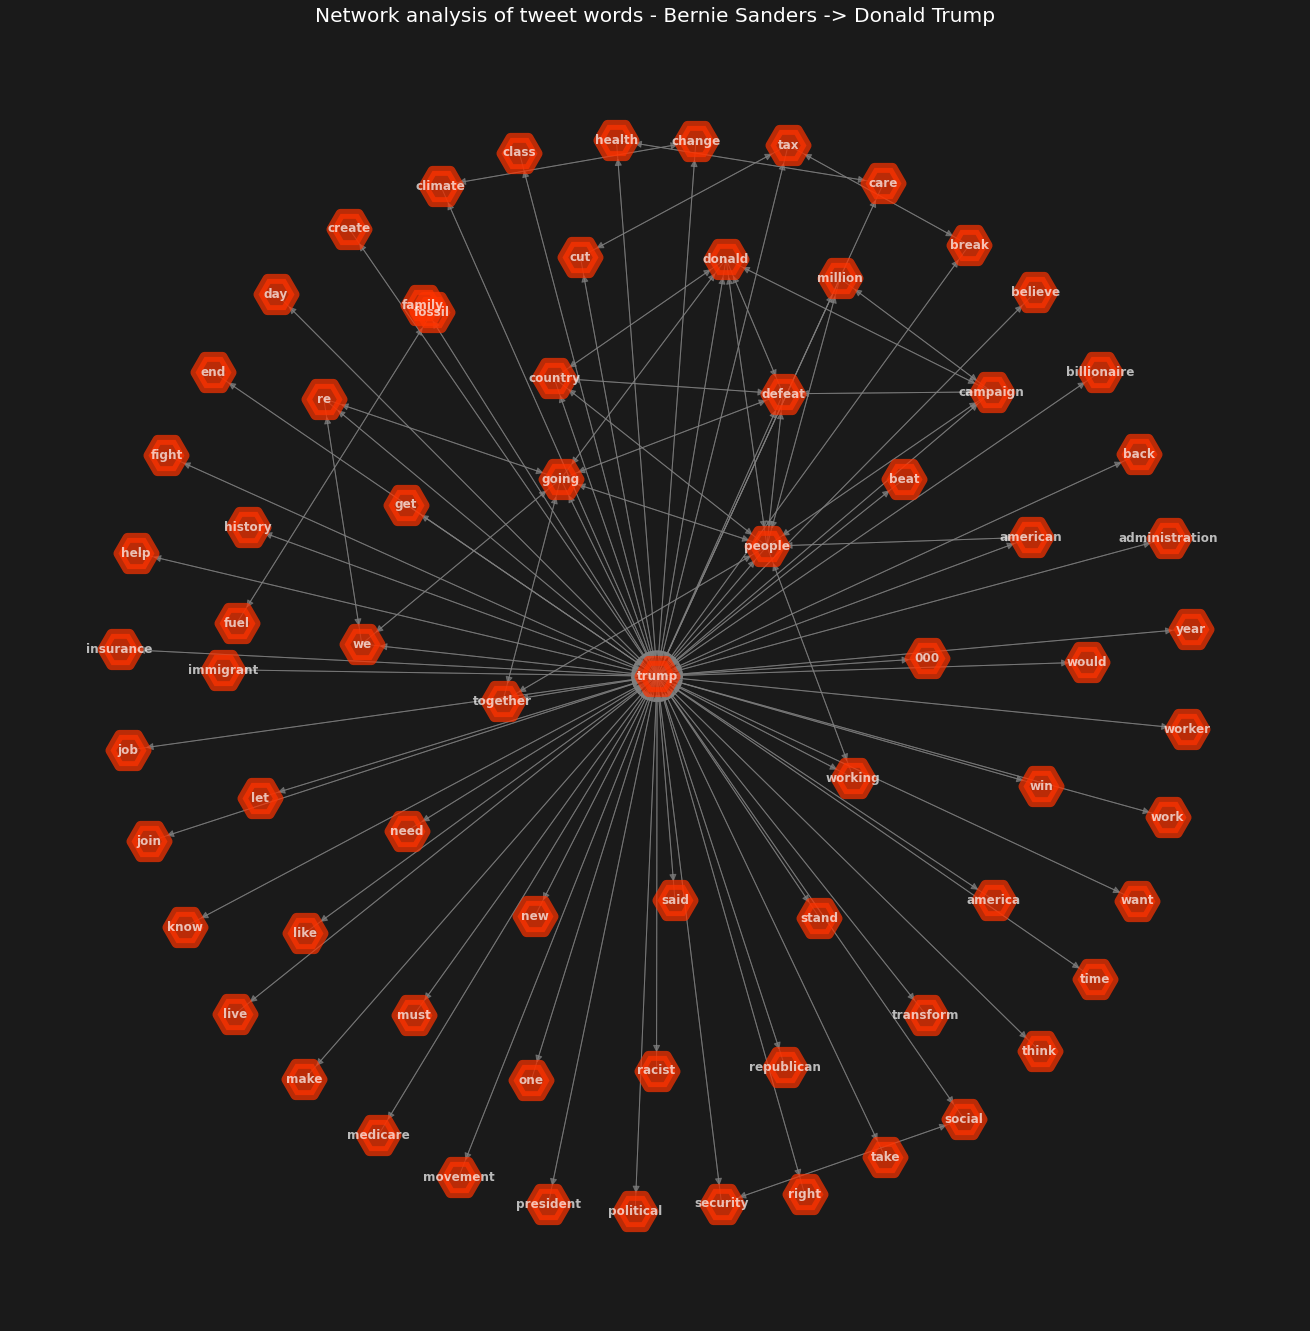

In [0]:
network_tweets(trump,40,"#FF3300","Network analysis of tweet words - Bernie Sanders -> Donald Trump")

**clustering on tweets about trump**

In [0]:
vectorizer = TfidfVectorizer(stop_words=stopwords,max_features=10000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X = vectorizer.fit_transform(trump['lemmatized_string'])

num_clusters = 30
km = KMeans(n_clusters=num_clusters,init='k-means++')
labels = km.fit_predict(X)
trump['cluster'] = labels


In [0]:
print("K-means clustering: \n")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print('\n')


K-means clustering: 

Cluster 0:
 campaign
 win
 donald trump
 donald
 beat
 best
 country
 possible
 movement
 vote


Cluster 1:
 climate
 change
 climate change
 hoax
 change hoax
 climate change hoax
 think
 trump think
 think climate change
 think climate


Cluster 2:
 tax break
 break
 tax
 huge tax break
 huge tax
 huge
 give
 billionaire
 tax break billionaire
 break billionaire


Cluster 3:
 tax
 worker
 break
 job
 cut
 tax break
 000
 break trump
 tax cut
 trump tax


Cluster 4:
 fuel
 fossil
 fossil fuel
 industry
 fuel industry
 fossil fuel industry
 climate
 energy
 company
 climate change


Cluster 5:
 going
 people together
 bring people together
 bring people
 people
 religion
 bring
 divide
 sexual
 orientation


Cluster 6:
 history
 president
 president modern
 modern
 president modern history
 modern history
 dangerous president
 dangerous
 president history
 corrupt


Cluster 7:
 wall street
 street
 wall
 executive
 street executive
 wall street executive
 financia

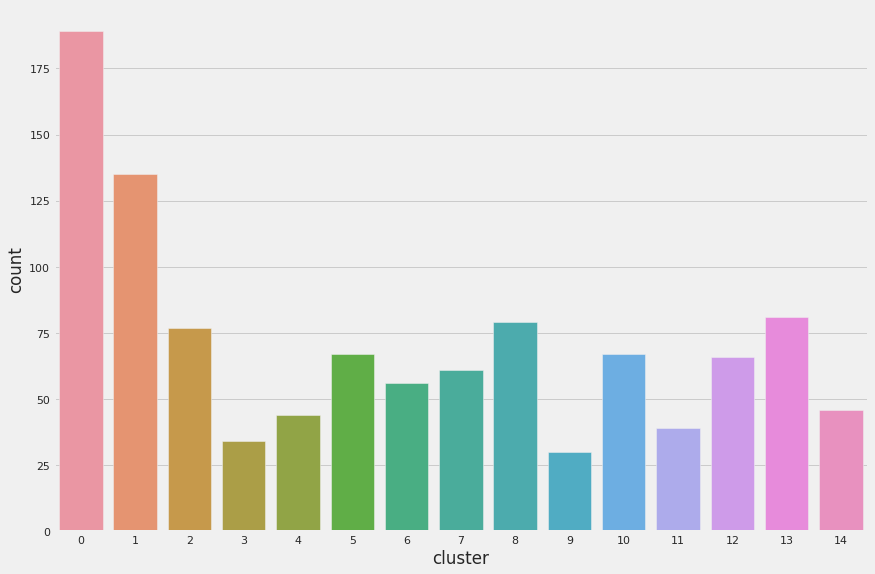

In [0]:
sns.countplot(x='cluster',data=trump)

**visualize clusters**

In [0]:
clusters = km.labels_.tolist()

In [0]:
import umap
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X)

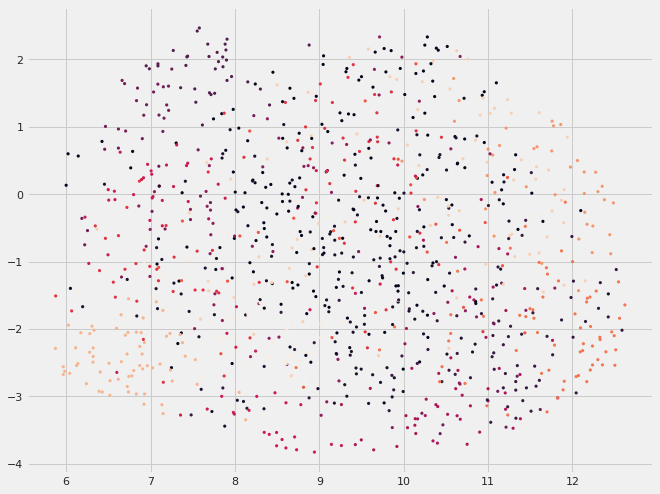

In [0]:
plt.figure(figsize=(10,8))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = clusters,
s = 10, # size
edgecolor='none')
plt.show()